### Import and initialize things

In [9]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import numpy.linalg as la
import sys, os
import pickle
import shapefile
#import rbf as RBF
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
sys.path.insert(0, os.environ['FaultSRC']) #add src folder to path for notebook
%load_ext snakeviz
%load_ext cython

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [10]:
#import the required additional libraries here
from tet_mesh import TetMesh
from dsi_interpolator import DSI
from fold_event import FoldEvent
#from ffold_event import FoldEvent
from structural_frame import StructuralFrame
from fold_rotation import FoldRotationAngle
from geological_points import *
from surfe_wrapper import *
from dsi_fold_constraint import DSIFoldConstraint
from fault_segment import FaultSegment

In [11]:
def rotation(axis,angle):
    c = np.cos(np.deg2rad(angle))
    s = np.sin((np.deg2rad(angle)))
    C = 1.0 - c
    x = axis[0]
    y = axis[1]
    z = axis[2]
    xs = x*s
    ys = y*s
    zs = z*s
    xC = x*C
    yC = y*C
    zC = z*C
    xyC = x*yC
    yzC = y*zC
    zxC = z*xC
    rotation_mat = np.zeros((3,3))
    rotation_mat[0][0] = x*xC+c
    rotation_mat[0][1] = xyC-zs
    rotation_mat[0][2] = zxC+ys
    
    rotation_mat[1][0] = xyC+zs
    rotation_mat[1][1] = y*yC+c
    rotation_mat[1][2] = yzC-xs

    rotation_mat[2][0] = zxC -ys
    rotation_mat[2][1] = yzC+xs
    rotation_mat[2][2] = z*zC+c
    return rotation_mat
    for i in range(3):
        for j in range(3):
            rv[i]+=rotation_mat[i][j]*vector[i]
        n+=rv[i]*rv[i]
    n = sqrt(n)
    for i in range(3):
        rv[i]/=n
    return rv
def mg2coords(X, Y, Z):
        return np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
def section2d(azi,dip,distance,origin=np.ones(3),scalev=np.ones(3),res=100):
    #create a unit square section
    xvalues = np.linspace(-1,1,res)
    yvalues = np.linspace(-1,1,res)
    zvalues = np.array([0.])
    
    X,Y,Z =  np.meshgrid(xvalues, yvalues, zvalues)
    
    #apply the dip rotation around y axis
    rot = rotation(np.array([0.,1.,0.]),dip)
    #apply the azi rotation around z
    rot2 = rotation(np.array([0.,0.,1.]),azi)
    scale = np.zeros((4,4))
    for i in range(3):
        scale[i,i] = scalev[i]
    xyz = mg2coords(X,Y,Z)
    xyz2=np.einsum('ij,kj->ki',rot,xyz)
    xyz3=np.einsum('ij,kj->ki',rot2,xyz2)
    xyz3 = np.c_[xyz3,np.ones(xyz3.shape[0])]
    xyz4=np.einsum('ij,kj->ki',scale,xyz3)
    xyz4=xyz4[:,:3]
    norm= np.zeros(3)
    norm[0] = np.cos(np.deg2rad(azi))*np.sin(np.deg2rad(dip))
    norm[1] = -np.sin(np.deg2rad(azi))*np.sin(np.deg2rad(dip))
    norm[2] = np.cos(np.deg2rad(dip))
    
    norm*=distance
    
    xyz4+=norm
    

    return xyz4
#print(xx.shape)

#plt.plot(xx[:,:,0], yy[:,:,0], marker='.', color='k', linestyle='none')

In [12]:
def add_value(A,B,x,y,i,r,s=1.0):
    A[r][4*i+0] = s*x**3
    A[r][4*i+1] = s*x**2
    A[r][4*i+2] = s*x
    A[r][4*i+3] = s*1.0
    B[r] = y
def add_dx(A,B,x,y,i,r,s=1.0):
    A[r][4*i+0] = s*3*x**2
    A[r][4*i+1] = s*2*x
    A[r][4*i+2] = s*1.0
    A[r][4*i+3] = s*0.0
    B[r] = y
def add_ddx(A,B,x,y,i,r,s=1.0):
    A[r][4*i+0] = s*6*x
    A[r][4*i+1] = s*2
    A[r][4*i+2] = 0.0
    A[r][4*i+3] = 0.0
    B[r] = y
def func(w,x):
    return w[0]*x**3+w[1]*x**2+w[2]*x+w[3]

def get_weights2(z):
    A = np.zeros((8,8))
    B = np.zeros(8)
    #set control points, 0 and 1
    add_value(A,B,x=-1,y=0,i=0,r=0)
    #add_value(A,B,x=1,y=0,i=0,r=1)
    add_value(A,B,x=-.5,y=1,i=0,r=1)
    #set gradient at edges
    add_dx(A,B,x=-0.5,y=.5,i=0,r=2)
    add_dx(A,B,x=0,y=0,i=0,r=3)
    #add_value(A,B,x=-0.8,y=0.8,i=0,r=2)

    w1 = np.linalg.lstsq(A,B)[0]
    return w1
def get_weights3(z):
    A = np.zeros((8,8))
    B = np.zeros(8)
    #set control points, 0 and 1
    add_value(A,B,x=-1,y=1,i=0,r=0)
    add_value(A,B,x=0,y=0,i=0,r=1)
    #add_value(A,B,x=-.5,y=1,i=0,r=1)
    #set gradient at edges
    add_dx(A,B,x=-1,y=0,i=0,r=2)
    add_dx(A,B,x=0,y=-1,i=0,r=3)
    #add_value(A,B,x=-0.8,y=0.8,i=0,r=2)

    w1 = np.linalg.lstsq(A,B)[0]
    return w1
def get_weights(z):
    A = np.zeros((8,8))
    B = np.zeros(8)
    add_value(A,B,x=-1,y=0,i=0,r=0)
    add_dx(A,B,x=-1,y=0,i=0,r=1)
    add_value(A,B,x=0,y=1,i=0,r=2)
    add_dx(A,B,x=0,y=0,i=0,r=3)
    add_value(A,B,x=-z,y=0,i=0,r=4)
    add_value(A,B,x=-z,y=0,i=1,r=4,s=-1.0)
    add_dx(A,B,x=-z,y=0,i=0,r=5)
    add_dx(A,B,x=-z,y=0,i=1,r=5,s=-1.0)
    #add_dx(A,B,x=0,y=-z,i=1,r=7,s=1.0)
    #add_ddx(A,B,x=0,y=0,i=1,r=6,s=1.0)
    #add_ddx(A,B,x=0,y=0,i=0,r=7,s=1.0)
    #add_ddx(A,B,x=0,y=0,i=1,r=6,s=1.0)
    add_value(A,B,x=0,y=0,i=1,r=6,s=1.0)
    #add_ddx(A,B,x=-1,y=0,i=0,r=7,s=1.0)
    #add_value(A,B,x=-1,y=0,i=0,r=7,s=1.0)
    add_dx(A,B,x=0,y=-1,i=1,r=7)

    w1 = np.linalg.lstsq(A,B)[0]
    return w1
def p5(x):
    y = np.copy(x)
    y[:] = 0
    y[x>0] = 1
    return y
def p4(x):
    w1 = get_weights3(0.)
    x2 = np.copy(x)
    
    x2[x>0] = -x2[x>0]
    y = func(w1[:4],x2)
    y[x>0] = -y[x>0]
    return y
def p1(x):
    w1 = get_weights2(0.)
    x2 = np.copy(x)
    
    x2[x>0] = -x2[x>0]
    y = func(w1[:4],x2)
    y[x2>-0.5] = 1.
    return y
def p0(x):
    w1 = get_weights(0)
    w2 = get_weights(0)
    x2 = np.copy(x)
    x2[x>0] = -x2[x>0]#if x>0:
    y = np.zeros(x.shape)
    y[np.logical_and(x>=-1,x<=0)] = func(w1[:4],x[np.logical_and(x>=-1,x<=0)])
    #y[np.logical_and(x>=-z,x<=0)] = 1#func(w1[4:],x[np.logical_and(x>=-z,x<=0)])
    y[np.logical_and(x>=0,x<=1)] = -func(w1[:4],-x[np.logical_and(x>=0,x<=1)])

    #yplt.plot(-x[np.logical_and(x<=1,x>=z)],-func(w2[:4],x[np.logical_and(x<=1,x>=z)]))
    #plt.plot(-x[np.logical_and(x<=z,x>=0)],-func(w2[4:],x[np.logical_and(x<=z,x>=0)]))
    return y
def p2(x):
    return np.ones(x.shape)
def fault_func2(p0,p1,p2,g0,g1,g2):
    return p0(g0)*p1(g1)*p2(g2)
def normalz(gx):
    gxn = np.zeros(gx.shape)
    gxn = (2./(np.max(gx[~np.isnan(gx)])-np.min(gx[~np.isnan(gx)])))
    gxn*=(gx-((np.min(gx[~np.isnan(gx)])+np.max(gx[~np.isnan(gx)]))/2.))
    gxn[np.isnan(gx)] = np.nan
    return gxn

def savePoints(filename,points,data):
    from pyevtk.hl import gridToVTK, pointsToVTK
    pointsToVTK('../data/'+filename,points[0,:],points[1,:],points[2,:],data)

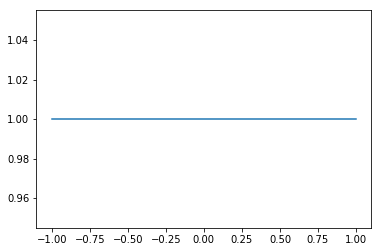

In [13]:
x = np.linspace(-1,1,100)
plt.plot(x,p2(x))

### Region manager

In [14]:
class RegionManager:
    def __init__(self,mesh):
        self.mesh = mesh
    def create_region_from_cuboid(self,corners,name):
        u = corners[0,:] - corners[1,:]
        v = corners[0,:] - corners[2,:]
        w = corners[0,:] - corners[3,:]
        
        ux = np.einsum('ij,j->i',mesh.nodes,u)
        vx = np.einsum('ij,j->i',mesh.nodes,v)
        wx = np.einsum('ij,j->i',mesh.nodes,w)
        vp1 = np.dot(v,corners[0,:])
        up1 = np.dot(u,corners[0,:])

        up2 = np.dot(u,corners[1,:])
        vp4 = np.dot(v,corners[2,:])
        wp1 = np.dot(w,corners[0,:])
        wp5 = np.dot(w,corners[3,:])
        logic = np.logical_and(ux<up1,ux>up2)#(condition = []
        logic = np.logical_and(logic,vx<vp1)
        logic = np.logical_and(logic,vx>vp4)
        logic = np.logical_and(logic,wx<wp1)
        logic = np.logical_and(logic,wx>wp5)
        region = np.zeros(mesh.n_nodes).astype(bool)
        region[logic] = 1
        self.mesh.regions[name] = region
    def create_region_from_boundary_box(self,boundarybox,name):
        corners = np.zeros((4,3))
        corners[0,:] = np.array([boundary_points[0,0],boundary_points[0,1],boundary_points[0,2]])
        corners[1,:] = np.array([boundary_points[0,0],boundary_points[1,1],boundary_points[0,2]])
        corners[2,:] = np.array([boundary_points[1,0],boundary_points[0,1],boundary_points[0,2]])
        corners[3,:] = np.array([boundary_points[0,0],boundary_points[0,1],boundary_points[1,2]])
        self.create_region_from_cuboid(corners,name)

    def create_region_from_property_value(self,propertyname,propertyvalue,region_name,sign=1):
        region = np.zeros(mesh.n_nodes).astype(bool)
        region[mesh.properties[propertyname]*sign>propertyvalue*sign] = 1
        self.mesh.regions[region_name] = region
    def create_properties_for_regions(self):
        for region in self.mesh.regions.keys():
            self.mesh.properties['REGION_%s'%region] = self.mesh.regions[region].astype(float)
        

### Build mesh for support and model


In [15]:
#First mesh is for the interpolation support and should be larger than the model area
boundary_points = np.zeros((2,3))
boundary_points[0,0] = -20
boundary_points[0,1] = -20
boundary_points[0,2] = -20
boundary_points[1,0] = 20
boundary_points[1,1] = 20
boundary_points[1,2] = 20
mesh = TetMesh('NormalFaults',)
mesh.setup_mesh(boundary_points,nstep=1,maxvol=.5,)
regionmanager = RegionManager(mesh)
regionmanager.create_region_from_boundary_box(boundary_points*.6,'r1')
regionmanager.create_properties_for_regions()
cg = mesh.get_constant_gradient(region=mesh.regions['everywhere'],shape='square')
# # second mesh is for the model area and the points can be moved around. No interpolation \
# # is performed on this mesh its just here because paraview can contour mesh objects not voxets
# boundary_points2 = np.zeros((2,3))
# boundary_points2=boundary_points*0.6
# mesh2 = TetMesh('Flower3DModel')
# mesh2.setup_mesh(boundary_points2,maxvol=0.5)

pickle.dump(mesh,open(os.environ['FaultDATA']+'/40x40x40x05mesh.pkl','wb'))

# boundary_points2 = np.zeros((2,3))
# boundary_points2=boundary_points*0.8
# mesh3 = TetMesh('Flower3DSupport2')
# mesh3.setup_mesh(boundary_points2,maxvol=0.01)
#First mesh is for the interpolation support and should be larger than the model area


In [16]:
print(mesh.n_elements)

250350


### Load the mesh object from a pickled file

In [17]:
mesh = pickle.load(open(os.environ['FaultDATA']+'/40x40x40x1mesh.pkl','rb'))

### FaultEvent

In [45]:
import networkx as nx
class FaultEvent:
    def __init__(self,mesh):
        self.mesh = mesh
        self.segment_graph = nx.DiGraph()
    def addSegment(self,fault_segment):
        self.segment_graph.add_node(fault_segment)
        return fault_segment
    def addOverlap(self,fault_segmenta,fault_segmentb,region):
        """
        Define where the segments of faults geometries overlap using a region 
        on the mesh
        """
        self.segment_graph.add_edge(fault_segmenta,fault_segmentb)
        self.segment_graph.edges[fault_segmenta,fault_segmentb]['region']=region
    def drawFaultTopology(self):
        nx.draw_networkx(self.segment_graph)
        

### Fault

In [7]:
def boolean_fault_function(gx,gy,gz,gx0,gy0,gz0,gxl,gyl,gzl):
    gxn = gx - gx0
    #gxn[gxn>gxl/2.] = np.nan
    #gxn[gxn<-gxl/2.] = np.nan
    gxn = normalz(gxn)

    gyn = gy - gy0
    gyn[gyn>gyl/2.] = np.nan
    gyn[gyn<-gyl/2.] = np.nan
    gyn = normalz(gyn)
    
    gzn = gz - gz0
    gzn[gzn>gzl/2.] = np.nan
    gzn[gzn<-gzl/2.] = np.nan
    gzn = normalz(gzn)
    ff2 = p5(gx)#fault_func2(p5,p2,p2,gxn,gyn,gzn)
    return gxn,gyn,gzn, ff2

In [8]:
#%%snakeviz
stratigraphy = DSI(mesh,region='everywhere',shape='square',solver='chol')
# for i in range(-15,15):
#     for j in range(-10,10):
#         stratigraphy.add_point([i,j,3*np.sin(j/5)],0.)
#         stratigraphy.add_point([i,j,3*np.sin(j/5)+1],1.)
stratigraphy.add_strike_dip_and_value([2.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([6.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([-6.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([0.1,0.1,1.1],90.,0.,0.)

stratigraphy.setup_interpolator(cg=.1)
stratigraphy.solve_system(solver='chol',clear=True)
mesh.update_property('strati',stratigraphy.c)


Setting up interpolator with 4 value control points 
        4 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000


In [28]:
# #%%snakeviz
shp = shapefile.Reader('/home/lgrose/lachlan.grose@monash.edu/GIS/modeling/fault_trace.shp')
geom = shp.shapes()
fault = FaultSegment(mesh=mesh,name='FaultSegment1',shape='square')
for f in geom:
    for p in f.points:
        fault.add_point([p[0],p[1],10],0,itype='gx')
#         fault.add_point([p[0],p[1],12],2,itype='gx')

fault.add_strike_and_dip([0,15,10],180.,85.,itype='gx')
# fault.add_strike_and_dip([15,15,10],90.,85.,itype='gx')
# fault.add_strike_and_dip([-15,-15,10],0.,85.,itype='gx')
fault.add_point([f.points[0][0],f.points[0][1],10],0,itype='gz')
fault.add_point([f.points[-1][0],f.points[-1][1],10],1,itype='gz')
fault.add_point([15,15,10],0,itype='gy')
fault.add_point([15,-15,-10],1,itype='gy')


flag = mesh.nodes[mesh.elements][:,:,2]<-10#depth
flag = np.logical_and(flag, mesh.nodes[mesh.elements][:,:,0]<-15)
flag = np.logical_and(flag, mesh.nodes[mesh.elements][:,:,1]>-10)
flag = np.all(flag,axis=1)
mesh.property_gradients['flag'] = flag.astype(float)
fault.interpolators['gx'].add_elements_gradient_orthogonal_constraint(np.arange(0,mesh.n_elements)[flag],np.array([0.,1.,0.])[None,:],w=.1,B=0.)
fault.interpolators['gx'].add_elements_gradient_orthogonal_constraint(np.arange(0,mesh.n_elements)[flag],np.array([1.,0.,0.])[None,:],w=.1)

fault.buildFaultFrame(solver='chol',gxxgy=0.1,gxxgz=1,gyxgz=0.05,gycg=5,gzcg=0.1,shape='square')



fault.interpolators['gx'].export_data_to_vtk('../data/f1gx_data')
fault.interpolators['gy'].export_data_to_vtk('../data/f1gy_data')
fault.interpolators['gz'].export_data_to_vtk('../data/f1gz_data')



Setting up interpolator with 17 value control points 
        1 gradient control points and 0 tangent control points and 
        constant gradient regularization
Setting up interpolator with 2 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization
Setting up interpolator with 2 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization


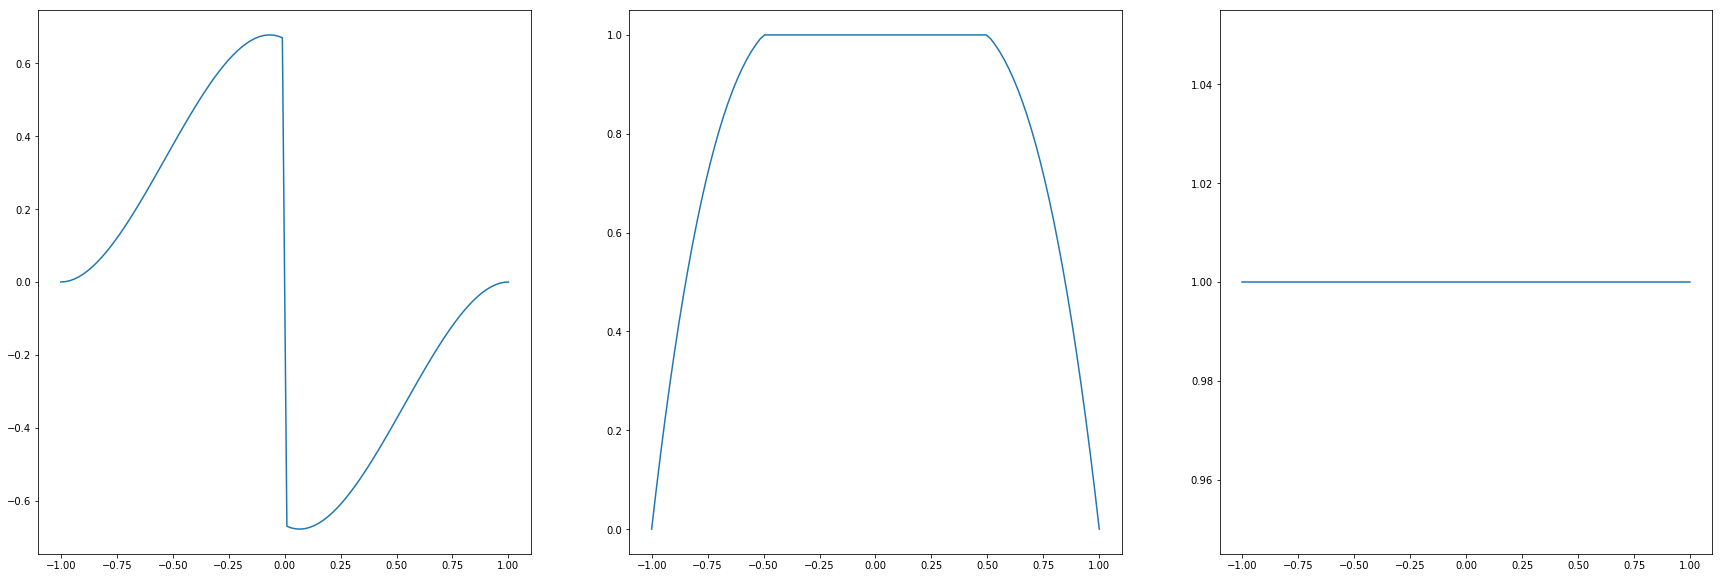

In [38]:
x = np.linspace(-1,1,100)
fig,ax = plt.subplots(1,3,figsize=(30,10))
ax[0].plot(x,p0(x))
ax[1].plot(x,p1(x))
ax[2].plot(x,p2(x))


In [41]:
def fault_func(p0,p1,p2,g0,g1,g2):
    g0[np.isnan(g0)] = 0.
    g1[np.isnan(g1)] = 0.
    g2[np.isnan(g2)] = 0.

    r = np.sqrt(g1*g1+g2*g2)
    return p0(g0)*((p1(r)*g1*g1+p2(r)*g2*g2)/(g1*g1+g2*g2))
def build_fault_function(gx,gy,gz,gx0,gy0,gz0,gxl,gyl,gzl):
    gxn = gx - gx0
    gxn[gxn>gxl/2.] = np.nan
    gxn[gxn<-gxl/2.] = np.nan
    gxn = normalz(gxn)

    gyn = gy - gy0
    gyn[gyn>gyl/2.] = np.nan
    gyn[gyn<-gyl/2.] = np.nan
    gyn = normalz(gyn)
    
    gzn = gz - gz0
    gzn[gzn>gzl/2.] = np.nan
    gzn[gzn<-gzl/2.] = np.nan
    gzn = normalz(gzn)
    ff2 = fault_func2(p0,p1,p2,gxn,gyn,gzn)
    ff2[np.isnan(ff2)] = 0
    return gxn,gyn,gzn, ff2

In [42]:
fault.buildFaultDisplacementField(faultfunction=build_fault_function,dm=-10)
newpoints = np.array(mesh.nodes[mesh.regions['r1']],copy=True, order='C')
newpoints  = fault.applyFault(newpoints,region='r1')
np.savetxt('fault1movedpoints.txt',newpoints,delimiter=',')

interp = np.zeros(mesh.properties['strati'].shape)
interp[:] = np.nan
interp[mesh.regions['r1']] = mesh.eval_interpolant(newpoints,'strati',k=50)
mesh.update_property('strati_int',interp)

### Testing solving methods

In [19]:
from sksparse.cholmod import * 

In [28]:
factor = analyze(fault.interpolators['gx'].AA,mode='simplicial')

In [29]:
%%snakeviz
factor.cholesky_inplace(fault.interpolators['gy'].AA.tocsc())

 
*** Profile stats marshalled to file '/tmp/tmpz77zu7kz'. 


In [22]:
factor2  = cholesky(fault.interpolators['gx'].AA)

In [30]:
factor2.cholesky_inplace(fault.interpolators['gx'].AA)

In [20]:
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.sparse import coo_matrix
def permute_sparse_matrix(M, order):
    permuted_row = order[M.row]
    permuted_col = order[M.col]
    new_M = coo_matrix((M.data, (permuted_row, permuted_col)), shape=M.shape)
    return new_M
order = reverse_cuthill_mckee(fault.interpolators['gx'].AA.tocsr())
permuted = permute_sparse_matrix(fault.interpolators['gx'].AA,order)


In [23]:
factor = cholesky(permuted)


In [24]:
#factor._common._use_long=True
c = factor(fault.interpolators['gx'].B[])

SyntaxError: invalid syntax (<ipython-input-24-06458543d8c1>, line 2)

In [14]:
factor.cholesky_inplace(permuted)